In [ ]:
import pandas as pd
from IPython.display import display, HTML
from jinja2 import Environment, FileSystemLoader
import os
import pathlib

In [ ]:
__file__ = 'src/qibocal/web/delete_me.ipynb'
WEB_DIR = pathlib.Path(__file__).parent
STYLES = WEB_DIR / "static" / "styles.css"
TEMPLATES = WEB_DIR / "templates"

In [ ]:
mydf = pd.DataFrame([{'a':1, 'b':2, 'c':3}])#, index=['hello'])

In [ ]:
mydf.to_html()#table_id=12, classes=['hello'], notebook=True)

In [ ]:
with open(STYLES) as file:
        css_styles = f"<style>\n{file.read()}\n</style>"

In [ ]:
mydf.style.css['row_heading'] = 'hi!'

In [ ]:
mydf = mydf.style.set_table_styles(
    [{'selector': 'thead th',
    'props': [('background-color', '#f0e6ff')]},
    # {'selector': 'thead th:first-child',
    # 'props': [('display','none')]},
    # {'selector': 'tbody th:first-child',
    # 'props': [('display','none')]}
    ]
)
# background-color: #f0e6ff;
#   padding: 8px;
#   text-align: center;
env = Environment(loader=FileSystemLoader(TEMPLATES))
template = env.get_template("test.html")
html = template.render(
    is_static=True,
    css_styles=css_styles,
    reports = mydf,
    )

In [ ]:
with open(os.path.join('delete_me/', "index.html"), "w") as file:
        file.write(html)

In [ ]:
HTML(html)

In [ ]:
import pandas as pd
import numpy as np

# Set up a DataFrame
np.random.seed(24)
df = pd.DataFrame({'A': np.linspace(1, 10, 10)})
df = pd.concat([df, pd.DataFrame(np.random.randn(10, 4), columns=list('BCDE'))],
               axis=1)
df.iloc[0, 2] = np.nan

df_html_output = df.style.set_table_styles(
    [{'selector': 'thead th',
    'props': [('background-color', '#f0e6ff'),
              ( 'padding', '8px'),
              ('text-align', 'center')]},
    # {'selector': 'thead th:first-child',
    # 'props': [('display','none')]},
    # {'selector': 'tbody th:first-child',
    # 'props': [('display','none')]}
    ]
).to_html()

HTML(df_html_output)
# html.append(df_html_output)
# body = '\r\n\n<br>'.join('%s'%item for item in html)
# msg.attach(MIMEText(body, 'html'))

In [172]:
from qibo.models import Circuit
from qibo import gates
import numpy as np

In [ ]:
c = Circuit(3)
c.add([gates.X(0), gates.Y(1), gates.CZ(0,2), gates.H(1), gates.M(0), gates.M(1)])

In [ ]:
nqubits = 3
qubits = [0,2]
layers = 4

gate_set = [gates.X, gates.Y, gates.H, gates.Unitary] #qasm

moments_int = np.random.randint(0, len(gate_set),size=(layers, len(qubits)))


init_kwargs_list = np.tile(np.arange(0, len(qubits)), layers).reshape((*moments_int.shape,1)).tolist()
# ? inverse ? what is faster? using matrices of gates or a analytic function?

collection_array = np.array([])
for l in init_kwargs_list:
    init_kwargs = np.empty(len(l), dtype=object)
    init_kwargs[:] = tuple(l)
    collection_array = np.append(collection_array, init_kwargs)
collection_array =  collection_array.reshape(layers, len(qubits))

In [ ]:
print(moments_int == 3)
for init_list in collection_array[moments_int == 3]:
    init_list.insert(0, np.random.uniform(0,1,(2,2)))

myc = Circuit(len(qubits))
for moment, moment_init in zip(moments_int, collection_array):
    for gate_index, init in zip(moment, moment_init):
        print(init)
        myc.add(gate_set[gate_index](*init))


In [ ]:
class sCircuit(Circuit):
    def __init__(self, nqubits, accelerators=None, density_matrix=False):
        super().__init__(nqubits, accelerators, density_matrix)

    def build(self, gate_set, moment_gates_indices, init_args=None):
        if init_args is None:
            init_args = np.tile(
                np.arange(0, len(qubits)), layers
            ).reshape((*moment_gates_indices.shape,1))

        for moment, moment_inits in zip(moment_gates_indices, init_args):
            for gate_index, init in zip(moment, moment_inits):
                self.add(gate_set[gate_index](*init))
    
    def compress(self):
        # ...
        # return gate_set, moment_gates_indices, init_args
        pass

    def save(self):
        # gate_set, moment_gates_indices, init_args =  self.compress()
        pass

    @classmethod
    def load(cls, path):
        # unpack file to gate_set, moment_gates_indices, init_args
        # obj = cls(len(moment_gates_inidices[0]))
        # obj.build(gate_set, moment_gates_indices, init_args)
        # return obj
        pass

In [174]:
from qibocal.auto.operation import Results
from dataclasses import dataclass, field
import numpy as np
from typing import List, Union
from qibocal.calibrations.niGSC.basics.fitting import fit_exp1B_func, exp1B_func
import plotly.graph_objects as go
from typing import Tuple, List


real_numeric = Union[int, float, np.number]
numeric = Union[int, float, complex, np.number]


# @dataclass
# class RResults(Results):
#     def render_html(self):
#         return "<div>"+self.__repr__()+"</div>"


@dataclass
class GSCResult(Results):
    key: str 
    summary: Results
    experiment_data: Union[str, List]

    def _plot(self):
        return self.summary._plot()

    def get_figures(self):
        return self.summary.get_figures()

    def get_tables(self):
        return self.summary.get_tables()
    # Handle not always load experimental data and pickle somewhere else. 

# TODO: MAYBE one class more!
# @dataclass
# class SingleDecayModel:
#     A: numeric = field(default=0.)
#     p: numeric = field(default=0.)
#     B: numeric = field(default=0.)
#     Aerr: numeric = field(default=0.)
#     perr: numeric = field(default=0.)
#     Berr: numeric = field(default=0.) 
#     fit: callable = fit_exp1B_func


@dataclass
class ResultContainer(Results):
    results: List[Results]
    summary: Results
    def _plot(self):
        for result in self.results:
            if hasattr(result, '_plot'):
                result._plot()

    def get_figures(self):
        figures = []
        for result in self.results:
            if hasattr(result, 'figure'):
                figures.extend(result.get_figures())
        return figures

    def get_tables(self):
        tables = []
        for result in self.results:
            if hasattr(result, 'get_tables'):
                tables.extend(result.get_tables())
        return tables


@dataclass
class DecayResult(Results):
    """
        y[i] = (A +- Aerr) (p +- perr)^m[i] + (B +- Berr)
        # for later: y= sum_i A_i p_i^m (needs m integer) 
    """
    y: List[numeric]
    m: List[numeric] = field(default_factory=list)
#    model: SingleDecayModel
    A: numeric = field(default=0.)
    Aerr: numeric = field(default=0.)
    p: numeric = field(default=0.)
    perr: numeric = field(default=0.)
    B: numeric = field(default=0.)
    Berr: numeric = field(default=0.)
#    figure: go.Figure = field(default_factory=go.Figure) #TODO: import plotly figure and do it!
    name: str = ''
    hist: Tuple[List[numeric], List[numeric], List[numeric]] = field(default_factory = lambda: (list(), list(), list()))
    fig: go.Figure = field(default_factory=go.Figure)

    def __post_init__(self):
        if len(self.m) == 0:
            self.m = list(range(len(self.y)))
        if len(self.y) != len(self.m):
            raise ValueError('Lenght of y and m must agree. len(m)={} != len(y)={}'.format(len(self.m), len(self.y)))

    def __str__(self):
        return 'DecayResult: {}, y = A p^m + B'.format(self.name)

    def _fit(self):
        params, errs, _ = fit_exp1B_func(self.m, self.y, p0=(self.A, self.p, self.B))
        self.A, self.p, self.B = params
        self.Aerr, self.perr, self.Berr = errs

    # can be defined by quicker by dataclass
    def _plot(self):
        self.fig = plot_decay_result(self)
        return self.fig

    def __str__(self):
        return u"({:.3f}\u00B1{:.3f})({:.3f}\u00B1{:.3f})^m + ({:.3f}\u00B1{:.3f})".format(
                self.A, self.Aerr, self.p, self.perr, self.B, self.Berr)

    def get_tables(self):
        return ['{} | {} '.format(self.name, str(self))]

    def get_figures(self):
        return [self.fig]

@dataclass
class MultiExponentialSeriesResult(Results): pass


# Design pattern, define result transformation
# Make transformation a type? 

def plot_decay_result(result: DecayResult, fig:go.Figure = None) -> go.Figure:
    if fig is None:
        fig = go.Figure()
    fig.add_trace(
        go.Scatter(
            x=result.m,
            y=result.y,
            line=dict(color="#aa6464"),
            mode="markers",
            name="average",
        )
    )
    m_fit = np.linspace(min(result.m), max(result.m), 100)
    y_fit = exp1B_func(m_fit, result.A, result.p, result.B)
    fig.add_trace(
        go.Scatter(
            x=m_fit,
            y=y_fit,
            name=str(result),
        line=go.scatter.Line(dash="dot")
        )
    )
    return fig

def plot_decay_result_scatter(result: DecayResult): pass

[4 3 3 4 3 4 4 3 4 3]


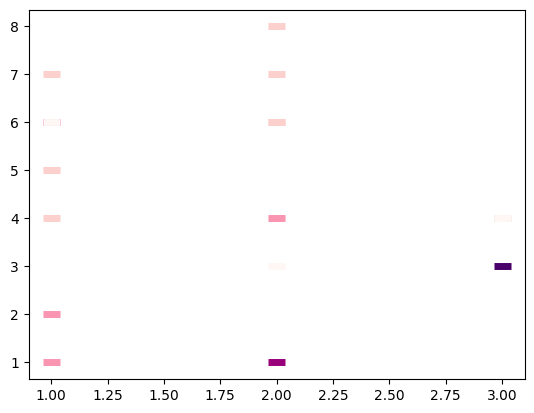

In [238]:
import matplotlib.pyplot as plt
size = 10
# fig, ax = plt.subplots(2, 2, figsize=(14, 7))
ydata1 = np.random.randint(0, 10, size=size)
ydata2 = np.random.randint(1, 9, size=size)
ydata3 = np.random.randint(3, 5, size=size)
ydata = np.array([ydata1, ydata2, ydata3])
yavg = np.mean(ydata, axis=1)
counts_list, bins_list = [], []
for data in ydata:
    counts, bins = np.histogram(data, bins=10,)
    counts_list.append(counts)
    bins_list.append(bins)
bins_array = np.array(bins_list)
bins_array = bins_array[::-1] + (bins_array[:1] - bins_array[:1])/2
plt.scatter([[1]*size, [2]*size, [3]*size], ydata, c=counts_list, cmap= plt.get_cmap('RdPu'), marker='_', linewidths=5, s=150)

# # plt.scatter([1]*10,ydata,c=np.arange(10), cmap = plt.get_cmap('Greys'))
# print(ydata)
# print(len(counts), len(bins))
# bins_middle = bins[:-1]+(bins[1] - bins[0])/2
# print(bins_middle)
# plt.scatter(
#     [1]*len(bins_middle), bins_middle, c=counts, cmap = plt.get_cmap('RdPu'), marker='_',
#                         linewidths=5, s=150)

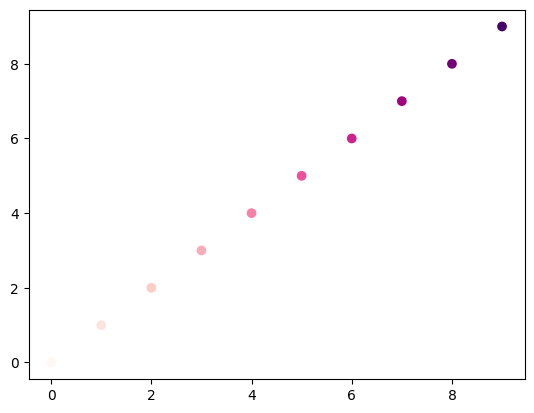

In [226]:
plt.scatter(np.arange(10), np.arange(10), c=np.arange(10), cmap=plt.get_cmap('RdPu'))

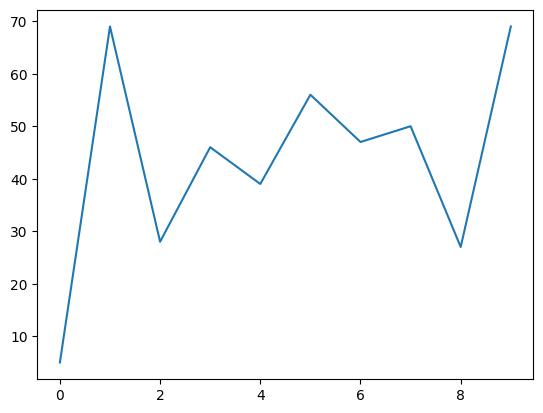

In [16]:
import matplotlib.pyplot as plt
import base64
from io import BytesIO

fig = plt.figure()
ydata = np.random.randint(0, 100, size=10)
plt.plot(ydata)

tmpfile = BytesIO()
fig.savefig(tmpfile, format='png')
encoded = base64.b64encode(tmpfile.getvalue()).decode('utf-8')

html = 'Some html head' + '<img src=\'data:image/png;base64,{}\'>'.format(encoded) + 'Some more html'

with open('test.html','w') as f:
    f.write(html)

                                              samples  depth  \
0   [[1], [0], [0], [0], [0], [1], [0], [1], [0], ...      1   
1   [[0], [1], [0], [1], [1], [0], [1], [0], [1], ...      3   
2   [[1], [0], [0], [1], [1], [1], [1], [0], [0], ...      5   
3   [[0], [1], [0], [0], [0], [0], [1], [1], [0], ...     10   
4   [[0], [0], [0], [1], [0], [0], [0], [0], [1], ...      1   
5   [[1], [1], [1], [1], [1], [0], [1], [0], [1], ...      3   
6   [[1], [0], [0], [1], [0], [1], [1], [0], [0], ...      5   
7   [[0], [1], [1], [0], [1], [0], [1], [1], [1], ...     10   
8   [[1], [0], [0], [1], [1], [0], [1], [1], [0], ...      1   
9   [[1], [0], [1], [0], [1], [1], [0], [0], [0], ...      3   
10  [[1], [0], [1], [1], [0], [1], [1], [1], [1], ...      5   
11  [[0], [1], [1], [0], [1], [1], [0], [0], [0], ...     10   
12  [[0], [1], [0], [0], [0], [0], [0], [0], [1], ...      1   
13  [[0], [0], [0], [0], [1], [1], [0], [1], [0], ...      3   
14  [[1], [0], [0], [0], [1], [1], [1], 

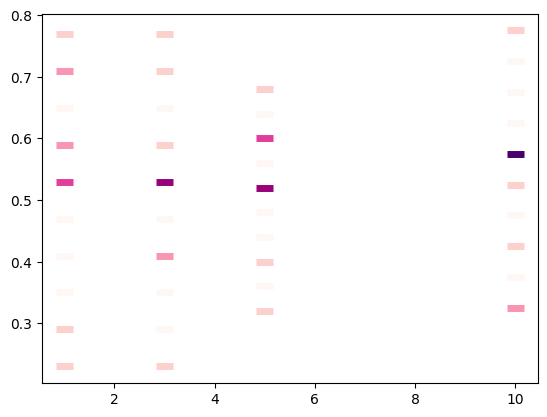

In [82]:
from qibocal.calibrations.niGSC.standardrb import *
from qibocal.calibrations.niGSC.basics.noisemodels import PauliErrorOnAll
from qibocal.protocols.characterization.RB.utils import extract_from_data
import plotly.graph_objects as go
import plotly.express as px
noise_model = PauliErrorOnAll()
niter = 10
f = ModuleFactory(1, [1,3,5,10]*10, [0])
e = ModuleExperiment(f, nshots=10, noise_model=noise_model)
e.perform(e.execute)
post_processing_sequential(e)
print(pd.DataFrame(e.data))
depth, y = extract_from_data(e.data, 'groundstate probability', 'depth')
depth = depth.reshape(-1, niter)
y = y.reshape(-1, niter)
df = get_aggregational_data(e)

counts_list, bins_list = [], []
for data in y:
    counts, bins = np.histogram(data, bins=10)
    counts_list.append(counts)
    bins_list.append(bins)
bins_array = np.array(bins_list)
print(bins_array[::,:-1])
print(bins_array[::,1] - bins_array[::,0])
bins_array = bins_array[::,:-1] + (np.array(bins_array[::,1] - bins_array[::,0]).reshape(-1,1))/2
plt.scatter(depth, bins_array, c=counts_list, cmap= plt.get_cmap('RdPu'), marker='_', linewidths=5, s=150)
fig = go.Figure()
fig = px.scatter(
        x=depth.flatten(),
        y=bins_array.flatten(),
        color = np.array(counts_list).flatten(),
        # line=dict(color="#aa6464"),
        # mode="markers",
        # name="average",
)
fig.show()

In [1]:
from qibocal.calibrations.niGSC.standardrb import *
from qibocal.calibrations.niGSC.basics.noisemodels import PauliErrorOnAll
from qibocal.protocols.characterization.RB.utils import extract_from_data
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
from qibocal.protocols.characterization.RB.result import DecayResult
noise_model = PauliErrorOnAll()
niter = 10
nshots = 200
f = ModuleFactory(1, [1,3,5,10, 20]*niter, [0])
data_list = []

# Execute
for c in f:
    depth = (c.depth - 2) if c.depth > 1 else 0
    if noise_model is not None:
        c = noise_model.apply(c)
    samples = c.execute(nshots=nshots).samples()
    data_list.append({'depth': depth, 'samples': samples})

# Aggregate
for element in data_list:
    element['p0'] = 1-np.mean(element['samples'])
df_data = pd.DataFrame(data_list)

# Histogram
m, p0 = extract_from_data(df_data, 'p0', 'depth')
p0_r = p0.reshape(-1, niter)
counts_list, bins_list = [], []
for data in p0_r:
    counts, bins = np.histogram(data, bins=10)
    counts_list.append(counts)
    bins_list.append(bins)

result = DecayResult(*extract_from_data(df_data, 'p0', 'depth', 'mean'), hists=(counts_list, bins_list))

# bins_array = np.array(bins_list)

# bins_array = bins_array[::,:-1] + (np.array(bins_array[::,1] - bins_array[::,0]).reshape(-1,1))/2
# # plt.scatter(depth, bins_array, c=counts_list, cmap= plt.get_cmap('RdPu'), marker='_', linewidths=5, s=150)
# fig = px.scatter(
#         x=np.repeat(result.m, bins_array.shape[-1]),
#         y=bins_array.flatten(),
#         color = np.array(counts_list).flatten(),
# )
# fig.show()

# fig = px.scatter(
#     x = m,
#     y = p0
# )
# fig.show()
result._fit()

result._plot()

# print(df_data.groupby('depth').agg(np.mean))#agg('mean'))
# print(df_data['samples'].mean(axis=0))
# print(extract_from_data(df_data, 'samples'))

# depth = depth.reshape(-1, niter)
# y = y.reshape(-1, niter)

# counts_list, bins_list = [], []
# for data in y:
#     counts, bins = np.histogram(data, bins=10)
#     counts_list.append(counts)
#     bins_list.append(bins)
# bins_array = np.array(bins_list)
# print(bins_array[::,:-1])
# print(bins_array[::,1] - bins_array[::,0])
# bins_array = bins_array[::,:-1] + (np.array(bins_array[::,1] - bins_array[::,0]).reshape(-1,1))/2
# plt.scatter(depth, bins_array, c=counts_list, cmap= plt.get_cmap('RdPu'), marker='_', linewidths=5, s=150)
# fig = go.Figure()
# fig = px.scatter(
#         x=depth.flatten(),
#         y=bins_array.flatten(),
#         color = np.array(counts_list).flatten(),
#         # line=dict(color="#aa6464"),
#         # mode="markers",
#         # name="average",
# )
# fig.show()

[Qibo 0.1.14|INFO|2023-05-22 11:40:03]: Using numpy backend on /CPU:0
